<a href="https://colab.research.google.com/github/fercouri/Resistencia-dos-Materiais/blob/main/resmat4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema 01

  Desenvolva uma rotina computacional para calcular a inclinação e deflexão de vigas isostáticas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Classe base para formas geométricas
class FormaGeometrica:
    def __init__(self, x_centro, y_centro, eh_furo=False):
        self.x_centro = float(x_centro)
        self.y_centro = float(y_centro)
        self.eh_furo = eh_furo  # Indica se a forma é um furo
        self.area = self.calcular_area() * (-1 if eh_furo else 1)  # Área negativa para furos

    def calcular_area(self):
        raise NotImplementedError("Método calcular_area deve ser implementado nas subclasses.")

    def calcular_inercia_x_central(self):
        raise NotImplementedError("Método calcular_inercia_x_central deve ser implementado nas subclasses.")

    def calcular_inercia_y_central(self):
        raise NotImplementedError("Método calcular_inercia_y_central deve ser implementado nas subclasses.")

# Classe para retângulos
class Retangulo(FormaGeometrica):
    def __init__(self, largura, altura, x_centro, y_centro, eh_furo=False):
        self.largura = float(largura)
        self.altura = float(altura)
        super().__init__(x_centro, y_centro, eh_furo)

    def calcular_area(self):
        return self.largura * self.altura

    def calcular_inercia_x_central(self):
        return (self.largura * self.altura ** 3) / 12

    def calcular_inercia_y_central(self):
        return (self.altura * self.largura ** 3) / 12

# Classe para círculos
class Circulo(FormaGeometrica):
    def __init__(self, raio, x_centro, y_centro, eh_furo=False):
        self.raio = float(raio)
        super().__init__(x_centro, y_centro, eh_furo)

    def calcular_area(self):
        return math.pi * self.raio ** 2

    def calcular_inercia_x_central(self):
        return (math.pi * self.raio ** 4) / 4

    def calcular_inercia_y_central(self):
        return self.calcular_inercia_x_central()  # Para círculos, Ix = Iy

# Classe para triângulos
class Triangulo(FormaGeometrica):
    def __init__(self, base, altura, x_centro, y_centro, eh_furo=False):
        self.base = float(base)
        self.altura = float(altura)
        super().__init__(x_centro, y_centro, eh_furo)

    def calcular_area(self):
        return (self.base * self.altura) / 2

    def calcular_inercia_x_central(self):
        return (self.base * self.altura ** 3) / 36

    def calcular_inercia_y_central(self):
        return (self.altura * self.base ** 3) / 36

# Função para calcular o centroide
def calcular_centroide(formas):
    area_total = sum(forma.area for forma in formas)
    if area_total == 0:
        raise ValueError("A área total da seção não pode ser zero.")
    x_centroide = sum(forma.area * forma.x_centro for forma in formas) / area_total
    y_centroide = sum(forma.area * forma.y_centro for forma in formas) / area_total
    return x_centroide, y_centroide

# Função para calcular o momento de inércia
def calcular_momento_inercia(tipo_secao, formas=None, x_centroide=None, y_centroide=None, **kwargs):
    if formas is None:
        # Seção simples (uma única forma)
        if tipo_secao == 'retangular':
            base = kwargs['base']
            altura = kwargs['altura']
            return (base * altura**3) / 12
        elif tipo_secao == 'circular':
            diametro = kwargs['diametro']
            return (math.pi * diametro**4) / 64
        elif tipo_secao == 'tubular':
            diametro_externo = kwargs['diametro_externo']
            diametro_interno = kwargs['diametro_interno']
            return (math.pi * (diametro_externo**4 - diametro_interno**4)) / 64
        elif tipo_secao == 'perfil_i':
            base = kwargs['base']
            altura = kwargs['altura']
            espessura_alma = kwargs['espessura_alma']
            espessura_mesa = kwargs['espessura_mesa']
            I_mesa = (base * espessura_mesa**3) / 12 + base * espessura_mesa * ((altura - espessura_mesa) / 2)**2
            I_alma = (espessura_alma * (altura - 2 * espessura_mesa)**3) / 12
            return 2 * I_mesa + I_alma
        else:
            raise ValueError("Tipo de seção transversal não suportado.")
    else:
        # Seção composta (várias formas)
        inercia_x_total = 0.0
        inercia_y_total = 0.0
        produto_inercia_total = 0.0

        for forma in formas:
            deslocamento_x = forma.x_centro - x_centroide
            deslocamento_y = forma.y_centro - y_centroide
            if forma.eh_furo:
                inercia_x_total -= forma.calcular_inercia_x_central() + abs(forma.area) * deslocamento_y ** 2
                inercia_y_total -= forma.calcular_inercia_y_central() + abs(forma.area) * deslocamento_x ** 2
                produto_inercia_total -= abs(forma.area) * deslocamento_x * deslocamento_y
            else:
                inercia_x_total += forma.calcular_inercia_x_central() + forma.area * deslocamento_y ** 2
                inercia_y_total += forma.calcular_inercia_y_central() + forma.area * deslocamento_x ** 2
                produto_inercia_total += forma.area * deslocamento_x * deslocamento_y

        return inercia_x_total, inercia_y_total, produto_inercia_total

# Definição das propriedades da viga e do material
class Viga:
    def __init__(self, comprimento, tipo_apoio, EI):
        self.comprimento = comprimento
        self.tipo_apoio = tipo_apoio
        self.EI = EI  # Módulo de elasticidade multiplicado pelo momento de inércia

# Função para calcular reações de apoio
def calcular_reacoes(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, tipo_apoio):
    soma_forcas_pontuais = sum(F for F, _ in cargas)
    soma_momentos_pontuais = sum(F * x for F, x in cargas)

    soma_forcas_uniformes = 0
    soma_momentos_uniformes = 0
    for q, a, b in carregamentos_uniformes:
        comprimento_carregamento = b - a
        forca_total = q * comprimento_carregamento
        posicao_resultante = a + comprimento_carregamento / 2
        soma_forcas_uniformes += forca_total
        soma_momentos_uniformes += forca_total * posicao_resultante

    soma_forcas_lineares = 0
    soma_momentos_lineares = 0
    for q_inicial, q_final, a, b in carregamentos_lineares:
        comprimento_carregamento = b - a
        forca_total = (q_inicial + q_final) * comprimento_carregamento / 2
        posicao_resultante = a + comprimento_carregamento * (q_inicial + 2 * q_final) / (3 * (q_inicial + q_final))
        soma_forcas_lineares += forca_total
        soma_momentos_lineares += forca_total * posicao_resultante

    soma_momentos_extremos = sum(M for _, M in momentos)

    soma_forcas = soma_forcas_pontuais + soma_forcas_uniformes + soma_forcas_lineares
    soma_momentos_A = soma_momentos_pontuais + soma_momentos_uniformes + soma_momentos_lineares + soma_momentos_extremos

    if tipo_apoio == 'simplesmente_apoiada':
        RB = soma_momentos_A / comprimento
        RA = soma_forcas - RB
    elif tipo_apoio == 'engastada':
        RA = soma_forcas
        MA = -soma_momentos_A
        return RA, MA
    elif tipo_apoio == 'biapoiada_com_balanco':
        RB = soma_momentos_A / comprimento
        RA = soma_forcas - RB
    else:
        raise ValueError("Tipo de apoio não suportado.")

    return RA, RB

# Função para calcular esforços internos
def calcular_esforcos_internos(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, RA, RB, tipo_apoio):
    x = np.linspace(0, comprimento, 1000)
    M = np.zeros_like(x)
    V = np.zeros_like(x)

    for i, xi in enumerate(x):
        momento = 0
        cortante = 0

        for F, posicao in cargas:
            if posicao <= xi:
                momento += F * (xi - posicao)
                cortante += F

        for q, a, b in carregamentos_uniformes:
            if a <= xi:
                comprimento_carregamento = min(xi, b) - a
                forca_total = q * comprimento_carregamento
                posicao_resultante = a + comprimento_carregamento / 2
                momento += forca_total * (xi - posicao_resultante)
                cortante += forca_total

        for q_inicial, q_final, a, b in carregamentos_lineares:
            if a <= xi:
                comprimento_carregamento = min(xi, b) - a
                q_xi = q_inicial + (q_final - q_inicial) * (xi - a) / (b - a)  # Intensidade em xi
                forca_total = (q_inicial + q_xi) * comprimento_carregamento / 2
                posicao_resultante = a + comprimento_carregamento * (q_inicial + 2 * q_xi) / (3 * (q_inicial + q_xi))
                momento += forca_total * (xi - posicao_resultante)
                cortante += forca_total

        for posicao, M_momento in momentos:
            if posicao <= xi:
                momento += M_momento

        if tipo_apoio == 'simplesmente_apoiada' or tipo_apoio == 'biapoiada_com_balanco':
            if xi >= 0:
                momento -= RA * xi
                cortante -= RA
            if xi >= comprimento:
                momento += RB * (xi - comprimento)
                cortante += RB
        elif tipo_apoio == 'engastada':
            if xi >= 0:
                momento += RB  # RB é interpretado como MA
                momento -= RA * xi
                cortante -= RA

        M[i] = momento
        V[i] = cortante

    return x, M, V

# Função para calcular inclinação e deflexão
def calcular_inclinacao_deflexao(x, M, EI):
    theta = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        M_sum = M[i-1] + M[i]
        theta[i] = theta[i-1] + M_sum * dx / (2 * EI)
        v[i] = v[i-1] + theta[i-1] * dx + M_sum * dx**2 / (4 * EI)

    return theta, v

# Função principal
def main():
    print("Cálculo da inclinação e deflexão de vigas")

    # Entrada do tipo de apoio
    while True:
        tipo_apoio = input("Digite o tipo de apoio (simplesmente_apoiada, engastada, biapoiada_com_balanco): ").strip().lower()
        if tipo_apoio in ['simplesmente_apoiada', 'engastada', 'biapoiada_com_balanco']:
            break
        print("Tipo de apoio inválido. Tente novamente.")

    # Entrada do comprimento da viga
    while True:
        try:
            comprimento = float(input("Digite o comprimento da viga (em metros): "))
            if comprimento > 0:
                break
            print("O comprimento da viga deve ser maior que zero.")
        except ValueError:
            print("Entrada inválida. Digite um número válido.")

    # Verifica se o usuário deseja inserir EI diretamente
    while True:
        try:
            usar_EI = input("Deseja inserir diretamente o valor de EI (módulo de elasticidade × momento de inércia)? (s/n): ").strip().lower()
            if usar_EI in ['s', 'n']:
                break
            print("Entrada inválida. Digite 's' para sim ou 'n' para não.")
        except ValueError:
            print("Entrada inválida. Digite 's' ou 'n'.")

    if usar_EI == 's':
        # Entrada de EI diretamente
        while True:
            try:
                EI = float(input("Digite o valor de EI (em N·m²): "))
                if EI > 0:
                    break
                print("O valor de EI deve ser maior que zero.")
            except ValueError:
                print("Entrada inválida. Digite um número válido.")
    else:
        # Entrada do tipo de seção transversal
        while True:
            tipo_secao = input("Digite o tipo de seção transversal (retangular, circular, tubular, perfil_i, composta): ").strip().lower()
            if tipo_secao in ['retangular', 'circular', 'tubular', 'perfil_i', 'composta']:
                break
            print("Tipo de seção transversal inválido. Tente novamente.")

        # Entrada dos parâmetros da seção transversal
        if tipo_secao == 'retangular':
            base = float(input("Digite a base da seção retangular (em metros): "))
            altura = float(input("Digite a altura da seção retangular (em metros): "))
            I = calcular_momento_inercia(tipo_secao, base=base, altura=altura)
        elif tipo_secao == 'circular':
            diametro = float(input("Digite o diâmetro da seção circular (em metros): "))
            I = calcular_momento_inercia(tipo_secao, diametro=diametro)
        elif tipo_secao == 'tubular':
            diametro_externo = float(input("Digite o diâmetro externo da seção tubular (em metros): "))
            diametro_interno = float(input("Digite o diâmetro interno da seção tubular (em metros): "))
            I = calcular_momento_inercia(tipo_secao, diametro_externo=diametro_externo, diametro_interno=diametro_interno)
        elif tipo_secao == 'perfil_i':
            base = float(input("Digite a base do perfil I (em metros): "))
            altura = float(input("Digite a altura do perfil I (em metros): "))
            espessura_alma = float(input("Digite a espessura da alma do perfil I (em metros): "))
            espessura_mesa = float(input("Digite a espessura da mesa do perfil I (em metros): "))
            I = calcular_momento_inercia(tipo_secao, base=base, altura=altura, espessura_alma=espessura_alma, espessura_mesa=espessura_mesa)
        elif tipo_secao == 'composta':
            # Entrada de formas geométricas para seção composta
            formas = []
            while True:
                try:
                    n_formas = int(input("Digite o número de formas geométricas na seção composta: "))
                    if n_formas > 0:
                        break
                    print("O número de formas deve ser maior que zero.")
                except ValueError:
                    print("Entrada inválida. Digite um número inteiro válido.")

            for i in range(n_formas):
                while True:
                    tipo_forma = input(f"Digite o tipo da forma {i+1} (retangular, circular, triangular): ").strip().lower()
                    if tipo_forma in ['retangular', 'circular', 'triangular']:
                        break
                    print("Tipo de forma inválido. Tente novamente.")

                if tipo_forma == 'retangular':
                    largura = float(input("Digite a largura do retângulo (em metros): "))
                    altura = float(input("Digite a altura do retângulo (em metros): "))
                    x_centro = float(input("Digite a coordenada x do centro do retângulo (em metros): "))
                    y_centro = float(input("Digite a coordenada y do centro do retângulo (em metros): "))
                    eh_furo = input("O retângulo é um furo? (s/n): ").strip().lower() == 's'
                    formas.append(Retangulo(largura, altura, x_centro, y_centro, eh_furo))
                elif tipo_forma == 'circular':
                    raio = float(input("Digite o raio do círculo (em metros): "))
                    x_centro = float(input("Digite a coordenada x do centro do círculo (em metros): "))
                    y_centro = float(input("Digite a coordenada y do centro do círculo (em metros): "))
                    eh_furo = input("O círculo é um furo? (s/n): ").strip().lower() == 's'
                    formas.append(Circulo(raio, x_centro, y_centro, eh_furo))
                elif tipo_forma == 'triangular':
                    base = float(input("Digite a base do triângulo (em metros): "))
                    altura = float(input("Digite a altura do triângulo (em metros): "))
                    x_centro = float(input("Digite a coordenada x do centro do triângulo (em metros): "))
                    y_centro = float(input("Digite a coordenada y do centro do triângulo (em metros): "))
                    eh_furo = input("O triângulo é um furo? (s/n): ").strip().lower() == 's'
                    formas.append(Triangulo(base, altura, x_centro, y_centro, eh_furo))

            # Calcula o centroide da seção composta
            x_centroide, y_centroide = calcular_centroide(formas)

            # Calcula o momento de inércia da seção composta
            I_x, I_y, _ = calcular_momento_inercia('composta', formas=formas, x_centroide=x_centroide, y_centroide=y_centroide)
            I = I_x  # Usa o momento de inércia em relação ao eixo x

        # Entrada do módulo de elasticidade do material
        while True:
            try:
                E = float(input("Digite o módulo de elasticidade do material (em Pa): "))
                if E > 0:
                    break
                print("O módulo de elasticidade deve ser maior que zero.")
            except ValueError:
                print("Entrada inválida. Digite um número válido.")

        # Calcula EI
        EI = E * I

    # Entrada de cargas pontuais
    cargas = []
    while True:
        try:
            n_cargas = int(input("Digite o número de cargas pontuais: "))
            if n_cargas >= 0:
                break
            print("O número de cargas deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida. Digite um número inteiro válido.")

    for i in range(n_cargas):
        while True:
            try:
                F = float(input(f"Digite a intensidade da carga {i+1} (em N): "))
                x = float(input(f"Digite a posição da carga {i+1} em relação ao apoio A (0 a {comprimento} m): "))
                if 0 <= x <= comprimento:
                    cargas.append((F, x))
                    break
                print(f"A posição deve estar entre 0 e {comprimento} m.")
            except ValueError:
                print("Entrada inválida. Digite números válidos.")

    # Entrada de carregamentos distribuídos
    # Entrada de carregamentos uniformemente distribuídos
    carregamentos_uniformes = []
    while True:
        try:
            n_uniformes = int(input("Digite o número de carregamentos uniformemente distribuídos: "))
            if n_uniformes >= 0:
                break
            print("O número de carregamentos deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida. Digite um número inteiro válido.")

    for i in range(n_uniformes):
        while True:
            try:
                q = float(input(f"Digite a intensidade do carregamento uniforme {i+1} (em N/m): "))
                a = float(input(f"Digite a posição inicial do carregamento uniforme {i+1} (0 a {comprimento} m): "))
                b = float(input(f"Digite a posição final do carregamento uniforme {i+1} (0 a {comprimento} m): "))
                if 0 <= a <= b <= comprimento:
                    carregamentos_uniformes.append((q, a, b))
                    break
                print(f"As posições devem estar entre 0 e {comprimento} m, e a posição final deve ser maior ou igual à inicial.")
            except ValueError:
                print("Entrada inválida. Digite números válidos.")

    # Entrada de carregamentos linearmente distribuídos
    carregamentos_lineares = []
    while True:
        try:
            n_lineares = int(input("Digite o número de carregamentos linearmente distribuídos: "))
            if n_lineares >= 0:
                break
            print("O número de carregamentos deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida. Digite um número inteiro válido.")

    for i in range(n_lineares):
        while True:
            try:
                q_inicial = float(input(f"Digite a intensidade inicial do carregamento linear {i+1} (em N/m): "))
                q_final = float(input(f"Digite a intensidade final do carregamento linear {i+1} (em N/m): "))
                a = float(input(f"Digite a posição inicial do carregamento linear {i+1} (0 a {comprimento} m): "))
                b = float(input(f"Digite a posição final do carregamento linear {i+1} (0 a {comprimento} m): "))
                if 0 <= a <= b <= comprimento:
                    carregamentos_lineares.append((q_inicial, q_final, a, b))
                    break
                print(f"As posições devem estar entre 0 e {comprimento} m, e a posição final deve ser maior ou igual à inicial.")
            except ValueError:
                print("Entrada inválida. Digite números válidos.")

    # Entrada de momentos aplicados
    momentos = []
    while True:
        try:
            n_momentos = int(input("Digite o número de momentos aplicados: "))
            if n_momentos >= 0:
                break
            print("O número de momentos deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida. Digite um número inteiro válido.")

    for i in range(n_momentos):
        while True:
            try:
                M = float(input(f"Digite o valor do momento {i+1} (em Nm): "))
                x = float(input(f"Digite a posição do momento {i+1} em relação ao apoio A (0 a {comprimento} m): "))
                if 0 <= x <= comprimento:
                    momentos.append((x, M))
                    break
                print(f"A posição deve estar entre 0 e {comprimento} m.")
            except ValueError:
                print("Entrada inválida. Digite números válidos.")

    # Criação da viga
    viga = Viga(comprimento, tipo_apoio, EI)

    # Cálculo das reações
    if tipo_apoio == 'engastada':
        RA, MA = calcular_reacoes(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, tipo_apoio)
    else:
        RA, RB = calcular_reacoes(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, tipo_apoio)

    # Cálculo dos esforços internos
    if tipo_apoio == 'engastada':
        x, M, V = calcular_esforcos_internos(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, RA, MA, tipo_apoio)
    else:
        x, M, V = calcular_esforcos_internos(cargas, carregamentos_uniformes, carregamentos_lineares, momentos, comprimento, RA, RB, tipo_apoio)

    # Cálculo da inclinação e deflexão
    theta, v = calcular_inclinacao_deflexao(x, M, EI)

    # Plotagem dos gráficos
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(x, theta, label='Inclinação (θ(x))')
    plt.xlabel('Posição (m)')
    plt.ylabel('Inclinação (rad)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x, v, label='Deflexão (v(x))')
    plt.xlabel('Posição (m)')
    plt.ylabel('Deflexão (m)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


**O código desenvolvido possui as seguintes funcionalidades:**

- Suporte a Diferentes Tipos de Apoio:

- Viga simplesmente apoiada.

- Viga engastada.

- Viga biapoiada com balanço.

- Suporte a Diferentes Tipos de Carregamento:

- Cargas pontuais.

- Carregamentos uniformemente distribuídos.

- Momentos aplicados.


O código foi desenvolvido em Python e utiliza as bibliotecas numpy para cálculos numéricos e matplotlib para plotagem de gráficos. A seguir, são descritas as principais funções e suas funcionalidades:

- Classe Viga

  Armazena as propriedades da viga, como comprimento, tipo de apoio, momento de inércia e módulo de elasticidade.

- Função calcular_reações

  Calcula as reações de apoio com base no tipo de apoio e nos carregamentos aplicados. Para vigas engastadas, retorna a reação vertical (RA) e o momento reativo (MA). Para vigas simplesmente apoiadas e biapoiadas com balanço, retorna as reações verticais (R A e R B).

- Função calcular_esforcos_internos

  Calcula o momento fletor (M) e a força cortante (V) ao longo da viga. Considera cargas pontuais, carregamentos distribuídos e momentos aplicados.

- Função calcular_inclinacao_deflexao

  Calcula a inclinação (θ(x)) e a deflexão (v(x)) da viga integrando o momento fletor.

- Função main

  Solicita ao usuário as informações necessárias para a análise da viga. Chama as funções para calcular as reações, esforços internos, inclinação e deflexão. Plota os gráficos de inclinação e deflexão.

### Limitações
O código possui algumas limitações e simplificações que devem ser consideradas:

- Carregamentos Lineares:

  O código não suporta carregamentos linearmente variáveis (triangulares ou trapezoidais). Apenas carregamentos uniformemente distribuídos são considerados.

- Seções Transversais Complexas:

  O código assume que o momento de inércia (I) é constante ao longo da viga. Seções transversais variáveis não são suportadas.

- Materiais Não Lineares:

  O código assume que o material da viga é linearmente elástico (lei de Hooke). Comportamentos não lineares não são considerados.

- Grandes Deflexões:

  O código utiliza a teoria de pequenas deflexões. Grandes deflexões, que podem alterar significativamente a geometria da viga, não são consideradas.

- Efeitos Dinâmicos:

  O código não considera efeitos dinâmicos, como vibrações ou carregamentos variáveis no tempo.

### Simplificações

A integração do momento fletor para calcular a inclinação e a deflexão é feita de forma numérica simples. Métodos mais precisos, como a integração de Simpson, poderiam ser utilizados para melhorar a precisão. O código não considera os efeitos de deformação por cisalhamento na deflexão da viga. Os apoios são considerados ideais, ou seja, não há deformação ou deslocamento nos apoios.

## Exemplos testados

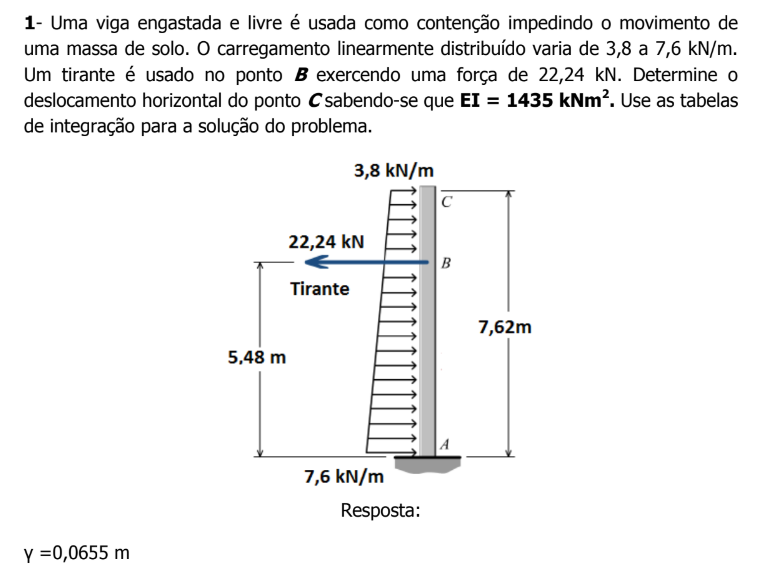

Usando as informações da imagem como input, temos:

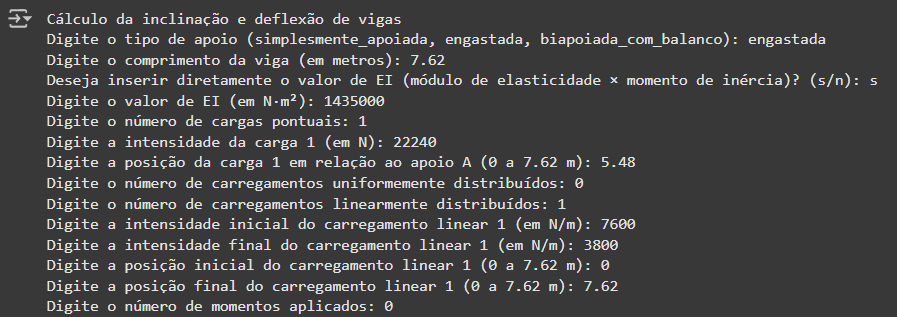

Temos o resultado:

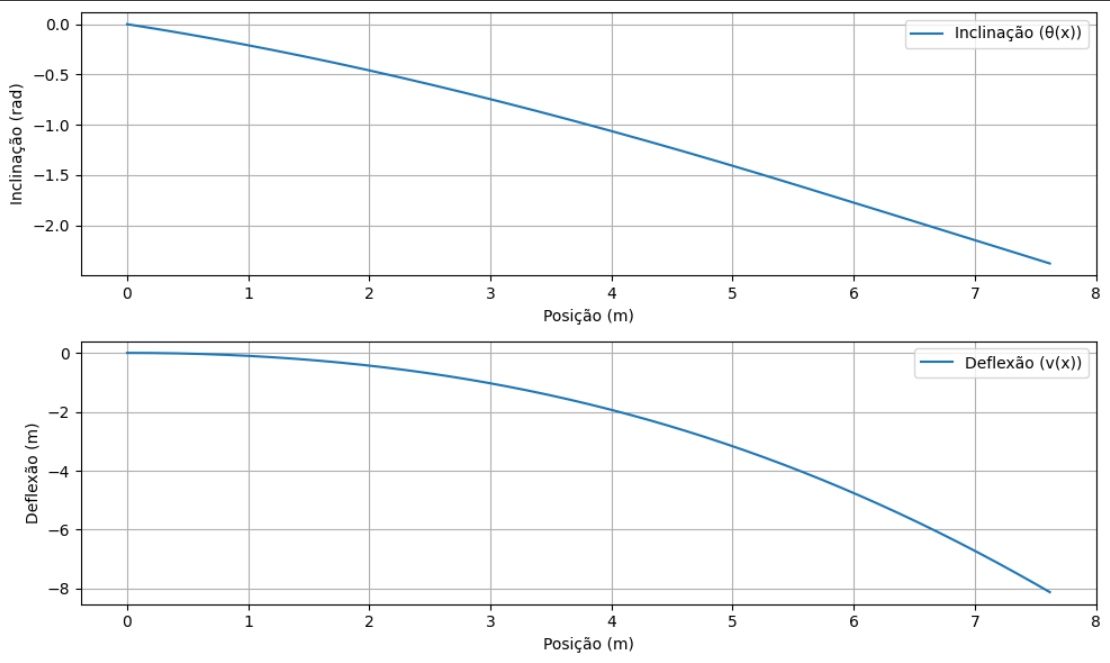

Colocando a questão no FTOOL temos:

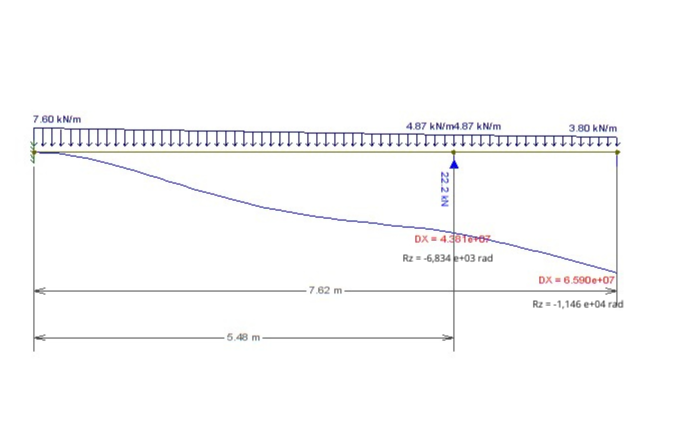

Para descobrir qual era a força linear em x = 5,48m fiz operações para descobrir a função linear que a rege. Aqui estão os cálculos:

f(x) = ax + b  
b = 7,6  
a = (3,8 - 7,6) / 7,62  = -0,498687664  
f(x) = -0,498687664 X + 7,6    
f(5,48) = -0,498687664 * 5,48 + 7,6  
f(5,48) = 4,86719 kN/m  
onde o software arredondou para 4,87 kN/m
Com a linha em azul sendo o gráfico de deflexão e o ponto Rz a inclinação nos pontos 2 e 3, respectivamente. Realizei a forma da viga na vertical no FTOOl, assim como na questão, apenas girei a fotografia para deixa-la na horizontal.

### Exemplo 2:

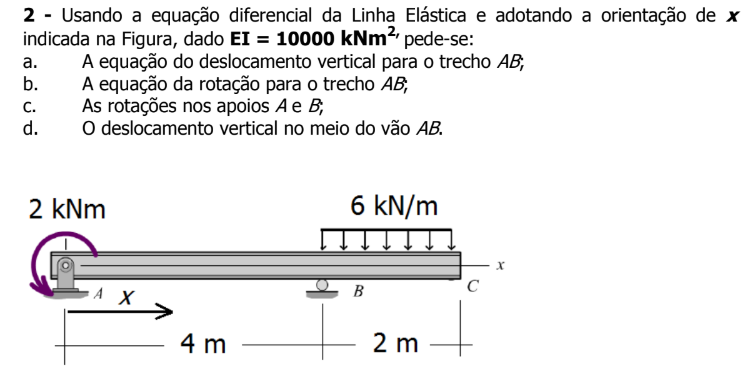

Usando as informações da imagem como input, temos:

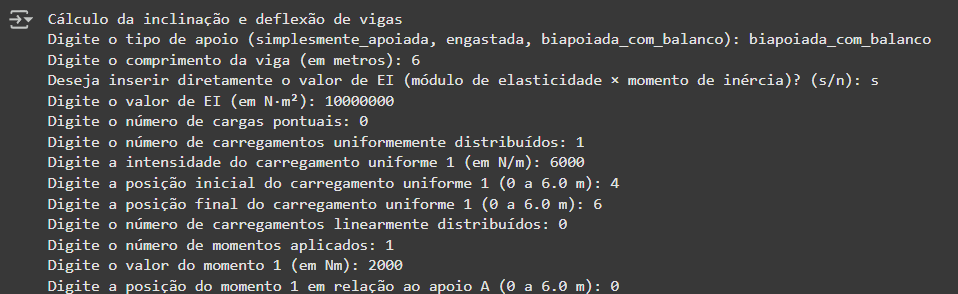

Temos:

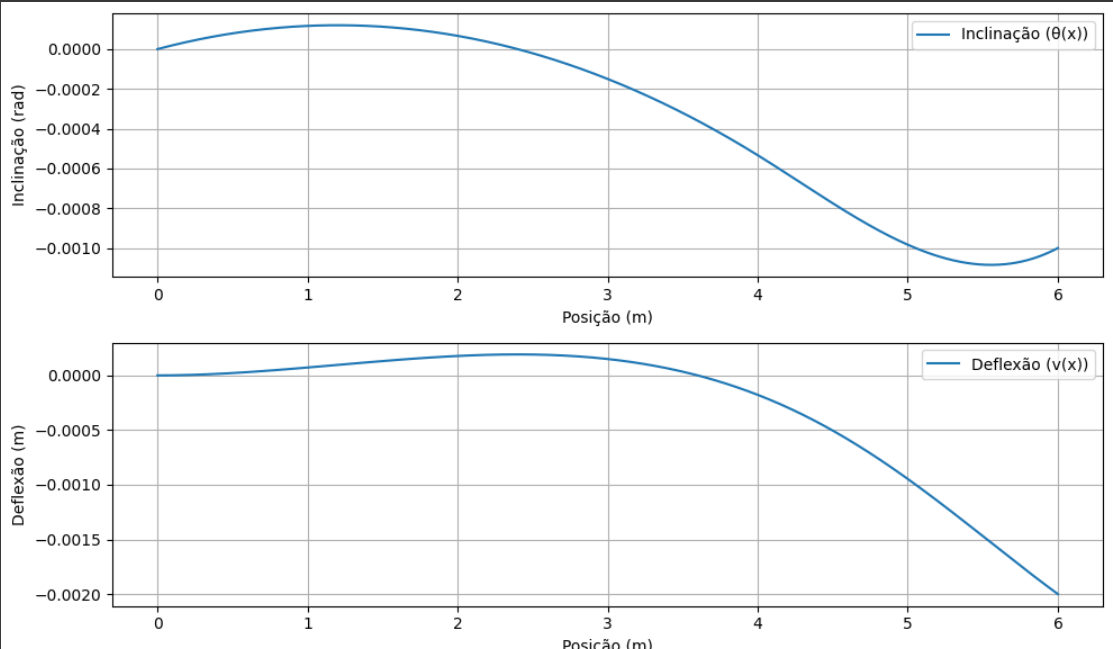

Colocando a questão no FTOOL temos:

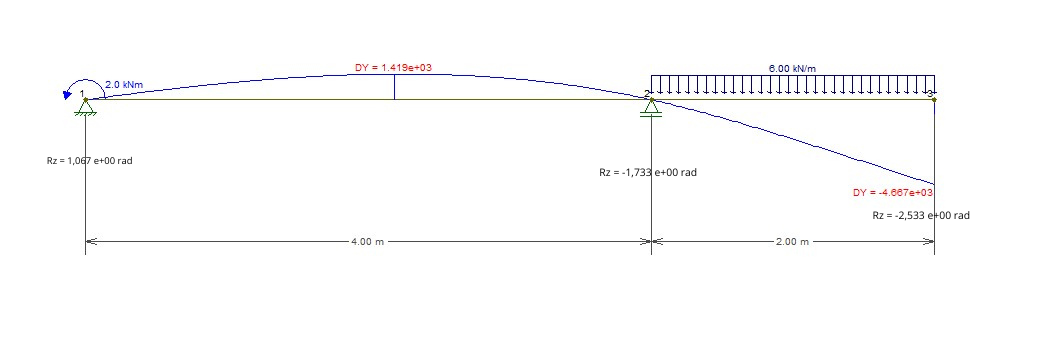

Com a linha em azul sendo o gráfico de deflexão e o ponto Rz a inclinação nos pontos 1, 2 e 3, respectivamente.